# Udacity Data Analyst Nanodegree
# Exploratory Data Analysis: What influences baseball salaries?

## Introduction


[Sean Lahman's](http://www.seanlahman.com/baseball-archive/statistics/) baseball data data set contains complete batting and pitching statistics from 1871 to 2014, plus fielding statistics, standings, team stats, managerial records, post-season data, and more. The data set provides a variety of opportunities for statistically driven investigations.

This study aims to identify the variables and/or factors that have the biggest influence on major league baseball player salaries. The study is divided separately for pitchers and batters, due to the inherent differences and roles between the two player types.

## Report Sections

This report starts with a data wrangling phase involving data importing, merging and cleaning. Once prepped, the data is analyzed in the exploration phase and conclusions and suggestions for future studies are presented in the final section. 



----------general notebook formatting examples


**Question 1**: Write at least two questions you think could be answered by data.

**Answer**:

1) What is/are the busiest times of the day for bike rentals?

2) What locations have the highest demand for bike rentals?

> **Tip**: If you double click on this cell, you will see the text change so that all of the formatting is removed. This allows you to edit this block of text. This block of text is written using [Markdown](http://daringfireball.net/projects/markdown/syntax), which is a way to format text using headers, links, italics, and many other options. You will learn more about Markdown later in the Nanodegree Program. Hit **Shift** + **Enter** or **Shift** + **Return**.


# Data Wrangling

In [274]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [344]:
import general_utils as Ugen
import matplotlib.pyplot as plt
import pandas as pd
import math
from pandas.tools.plotting import scatter_matrix
import numpy as np
import seaborn as sns
from scipy import stats

sns.set(color_codes=True)

In [306]:
#GET DATA
pitcher_df=pd.read_csv('baseballdata/Pitching.csv') 
batter_df=pd.read_csv('baseballdata/Batting.csv') 
salary_df=pd.read_csv('baseballdata/Salaries.csv') 

In [307]:
#EXPLORE DATA
batter_df.head() #print first 5 entries

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,...,13,8,1,4,0,NaN,NaN,NaN,NaN,NaN
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,...,19,3,1,2,5,NaN,NaN,NaN,NaN,NaN
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,...,27,1,1,0,2,NaN,NaN,NaN,NaN,NaN
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,...,16,6,2,2,1,NaN,NaN,NaN,NaN,NaN


In [308]:
#EXPLORE DATA
salary_df.head() #print first 5 entries

,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
2,1985,ATL,NL,benedbr01,545000
3,1985,ATL,NL,campri01,633333
4,1985,ATL,NL,ceronri01,625000


**Thoughts**: Right away, we can see that the salary data starts in 1985, whereas the batter data starts in 1871. Let's find out what range of years is covered in each data set.

In [309]:
##FIND WHAT YEARS ARE COVERED
batter_years=list(batter_df['yearID'].values)
salary_years=list(salary_df['yearID'].values)

print ('batter_df covers %d-%d' % (min(batter_years),max(batter_years)))
print ('salary_df covers %d-%d' % (min(salary_years),max(salary_years)))


batter_df covers 1871-2015
salary_df covers 1985-2015


In [310]:
#Clean up pitchers data table to eliminate years without salary data
pitcher_df=pitcher_df[pitcher_df['yearID']>=1985]
batter_df=batter_df[batter_df['yearID']>=1985]

print (len(pitcher_df.index))
print (len(batter_df.index))
print (len(salary_df.index))

19159
39095
25575


**Thoughts**: Looks like we are still limited by availability of salary data. Rather than filtering down the datasets until they match, it makes more sense to perform an inner join between the two datasets.

In [311]:
##JOIN DATASETS
df=salary_df.merge(batter_df,'inner',['yearID','playerID','teamID'])

print(len(df.index))
df.head()

24628


,yearID,teamID,lgID_x,playerID,salary,stint,lgID_y,G,AB,R,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,1985,ATL,NL,barkele01,870000,1,NL,20,17,0,...,0,0,1,0,7,0,0,0,0,0
1,1985,ATL,NL,bedrost01,550000,1,NL,37,64,3,...,1,0,0,1,22,0,0,6,0,0
2,1985,ATL,NL,benedbr01,545000,1,NL,70,208,12,...,20,0,1,22,12,1,1,4,2,8
3,1985,ATL,NL,campri01,633333,1,NL,66,13,1,...,2,0,0,1,5,0,0,1,0,0
4,1985,ATL,NL,ceronri01,625000,1,NL,96,282,15,...,25,0,3,29,25,1,1,0,4,15


In [312]:
##Investigate size reduction in df (from the original salary_df I was joining on)
players_1=df['playerID'].unique()
players_2=salary_df['playerID'].unique()

missing_players=[player for player in players_2 if player not in players_1]
len(missing_players)

149

**Comments**: As can be seen, I lost some players in the inner join. My hypothesis is that these are players who never ended up playing and therefore didn't accumulate any stats.

#salary_df[salary_df['playerID'].isin(missing_players)]

In [313]:
##Check for rows with any missing values
print(len(df[df.isnull().any(axis=1)].index))
df[df.isnull().any(axis=1)].head()

1877


,yearID,teamID,lgID_x,playerID,salary,stint,lgID_y,G,AB,R,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
23,1985,BAL,AL,davisst02,437500,1,AL,31,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,1985,BAL,AL,flanami01,641667,1,AL,15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,1985,BAL,AL,martide01,560000,1,AL,33,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,1985,BAL,AL,martiti01,440000,1,AL,49,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,1985,BAL,AL,mcgresc01,547143,1,AL,35,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [314]:
##Get rid of rows with NaNs
df=df.dropna()
len(df)

22751

In [315]:
##Check if they were dropped
print(len(df[df.isnull().any(axis=1)].index))
df[df.isnull().any(axis=1)].head()

0


,yearID,teamID,lgID_x,playerID,salary,stint,lgID_y,G,AB,R,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP


Success!

In [316]:
##Finally, get rid of any batter who never had an at-bat, or didn't have more than 20 at-bats
##This is done since players with so few plate appearances greatly skew the various batting statistics

print(len(df))
df=df[df['AB']>20]
len(df)

22751


14904

# Data Exploration

In [317]:
##One of the best ways to start is with the handy built-in pandas function; describe!
df.describe().round(0)

,yearID,salary,stint,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
count,14904,14904,14904,14904,14904,14904,14904,14904,14904,14904,14904,14904,14904,14904,14904,14904,14904,14904,14904,14904
mean,2000,2355841,1,90,284,38,75,15,2,8,37,6,2,28,52,2,3,3,2,6
std,9,3692685,0,47,195,32,58,12,2,10,32,9,3,25,37,4,3,3,3,6
min,1985,0,1,6,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25%,1993,310000,1,42,93,10,21,4,0,1,9,0,0,7,22,0,0,0,0,2
50%,2000,700000,1,93,261,31,65,12,1,5,29,2,1,22,44,1,1,1,2,5
75%,2008,2800000,1,134,461,62,123,23,2,13,57,7,3,42,76,3,4,4,4,10
max,2015,33000000,3,163,716,152,262,59,23,73,165,110,29,232,223,120,35,39,17,35


**Comments**: 

Describe returns a number of useful statistics, such as the count, mean, standard deviation, and quartiles. A few observations:

- Observing the count column gives us an indication of which columns are missing values and how many they are missing. All columns have the same number of values, indicating that the data wrangling was successful in eliminating values.

- Comparing the mean salary to the 50% & 75% percentiles shows that the mean has been heavily skewed by large salaries, since the mean is above the 75% percentile. This is further explored later on.

kurtosis: 9.47498514417
skew: 2.79401077468


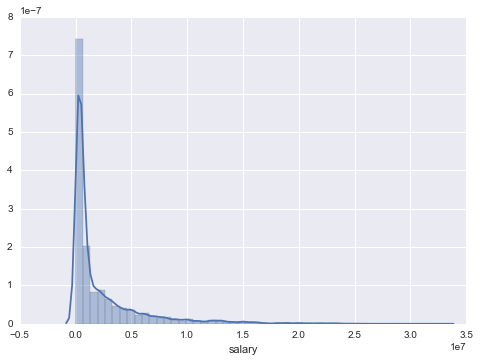

In [318]:
print('kurtosis: %s'% df.salary.kurtosis())
print('skew: %s'% df.salary.skew())
sns.distplot(df['salary']);

**Comments**: As expected, the salary distribution is highly skewed to the right, due to a small number of very large salaries. Since the data contains salaries from 1985-2015, it is possible that the data is slightly skewed by lower salaries from earlier years.

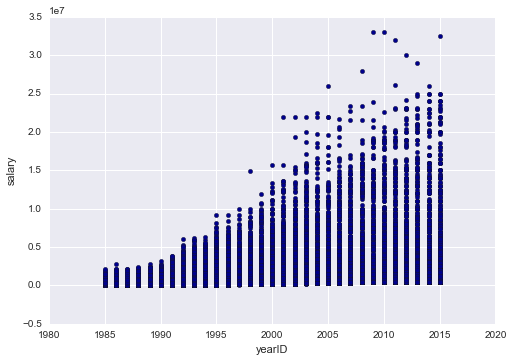

In [319]:
df.plot(kind='scatter', x='yearID', y='salary',color='DarkBlue');

**Comments**: As shown above, salaries increase significantly over time. This is likely due to both inflation and higher team payrools. Unless these factors are adjusted for, salary data from earlier years cannot be used. 

In [320]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_


##produce salary summary statistics for each year
yearly_df=df[df['yearID']>2000].groupby('yearID')['salary'].agg([sum,max,min,np.mean,percentile(25),np.median,percentile(75)])
yearly_df

,sum,max,min,mean,percentile_25,median,percentile_75
yearID,,,,,,,
2001,1338899774,22000000,200000,2677799,286875,1100000,4270833
2002,1378589448,22000000,200000,2848325,332500,1150000,4500000
2003,1478777028,22000000,165574,3005644,339375,1000000,4337500
2004,1431799823,22500000,300000,2934016,345000,975000,4016666
2005,1534925773,26000000,300000,3191113,365000,1300000,4312500
2006,1548780119,21680727,327000,3295276,374250,1262500,4458750
2007,1633184505,23428571,380000,3460136,400000,1575000,4756250
2008,1817076500,28000000,390000,3833494,411000,1500000,5500000
2009,1844379067,33000000,400000,3974954,435000,1965625,5925000


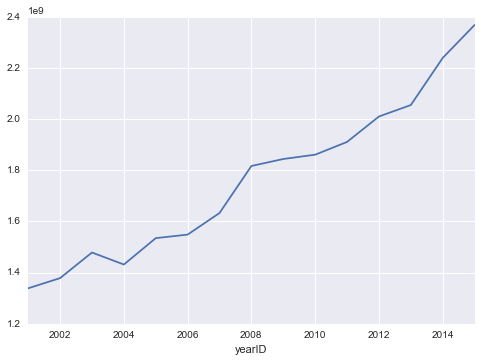

In [321]:
##Total league salaries over time 
yearly_df['sum'].plot();

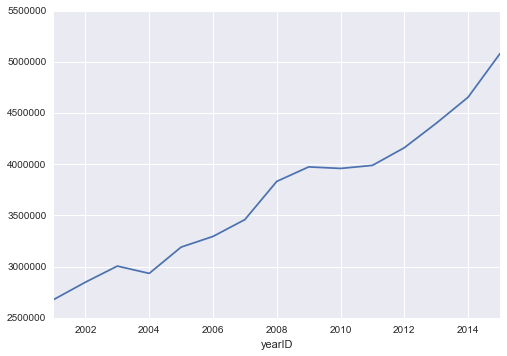

In [322]:
##Average salary over time
yearly_df['mean'].plot();

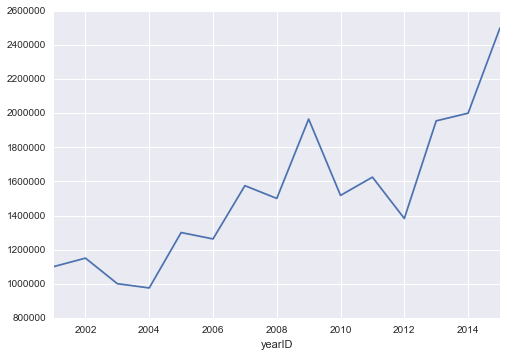

In [323]:
##Median salary over time
yearly_df['median'].plot();

**Comments**: Based on the three plots above, I chose to use the salary data from 2008-2011 as the salary data was the most similiar among these years (based on the sum, mean and median).

kurtosis: 3.63990566147
skew: 1.83742157835


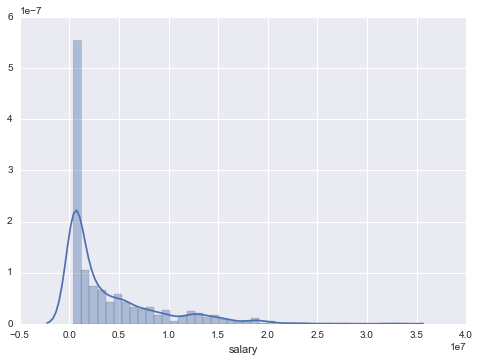

In [324]:
df=df[(df['yearID']>2007)&(df['yearID']<2012)]

print('kurtosis: %s'% df.salary.kurtosis())
print('skew: %s'% df.salary.skew())
sns.distplot(df['salary']);

**Comments**: While filtering did reduce both the skew and kurtosis of the salary distribution, it is still heavily skewed by large salaries.

To create a more normal distribution, the log of the salaries is taken.

kurtosis: -1.36436214281
skew: 0.255458196654


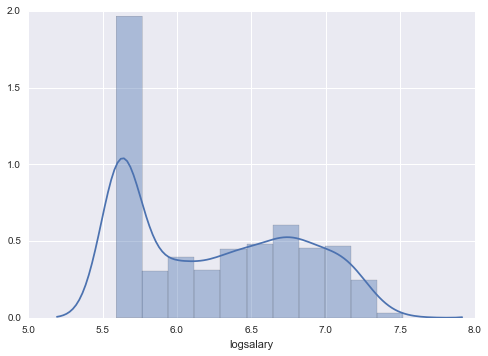

In [325]:
df['logsalary']=df.apply(lambda df: math.log10(df['salary']),axis=1)

print('kurtosis: %s'% df.logsalary.kurtosis())
print('skew: %s'% df.logsalary.skew())
sns.distplot(df['logsalary']);

Taking the log of the salaries reduces both the skewness and kurtosis significantly.

Next, I explore the impact of the league and the team on a player's salary.

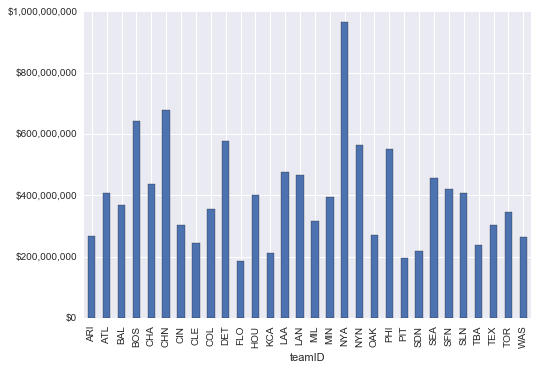

In [326]:
team_df=df.groupby('teamID')['salary'].agg([sum,max,min,np.mean,np.median])
ax=team_df['mean'].plot(kind='bar')

# format y-axis as currency
vals = ax.get_yticks()
ax.set_yticklabels(['${:,.0f}'.format(x*100) for x in vals]);

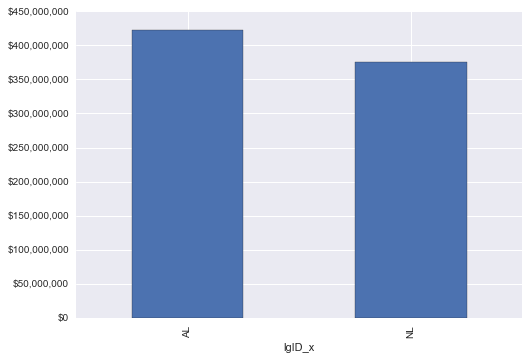

In [327]:
league_df=df.groupby('lgID_x')['salary'].agg([sum,max,min,np.mean,np.median])
ax=league_df['mean'].plot(kind='bar')

# format y-axis as currency
vals = ax.get_yticks()
ax.set_yticklabels(['${:,.0f}'.format(x*100) for x in vals]);

**Additional Stats**

Before exploring the relationships between the variables present in the table, additional statistics are computed.

- OBP (on-base percentage) = (Hits + Walks + Hit by Pitch) / (At Bats + Walks + Hit by Pitch + Sacrifice Flies)

- SLG (slugging percentage) = (1*1B + 2*2B + 3*3B + 4*HR)/AB 

- OPS (on-base plus slugging) = OBP + OPS

- BA (batting avg) = H/AB

In [328]:
df['OBP']=(df['H']+df['BB']+df['IBB']+df['HBP'])/(df['AB']+df['BB']+df['IBB']+df['HBP']+df['SF'])
df['BA']=df['H']/df['AB']
df['1B']=df['H']-df['2B']-df['3B']-df['HR']
df['SLG']=(df['1B']+2*df['2B']+3*df['3B']+4*df['HR'])/df['AB']
df['OPS']=df['SLG']+df['OBP']

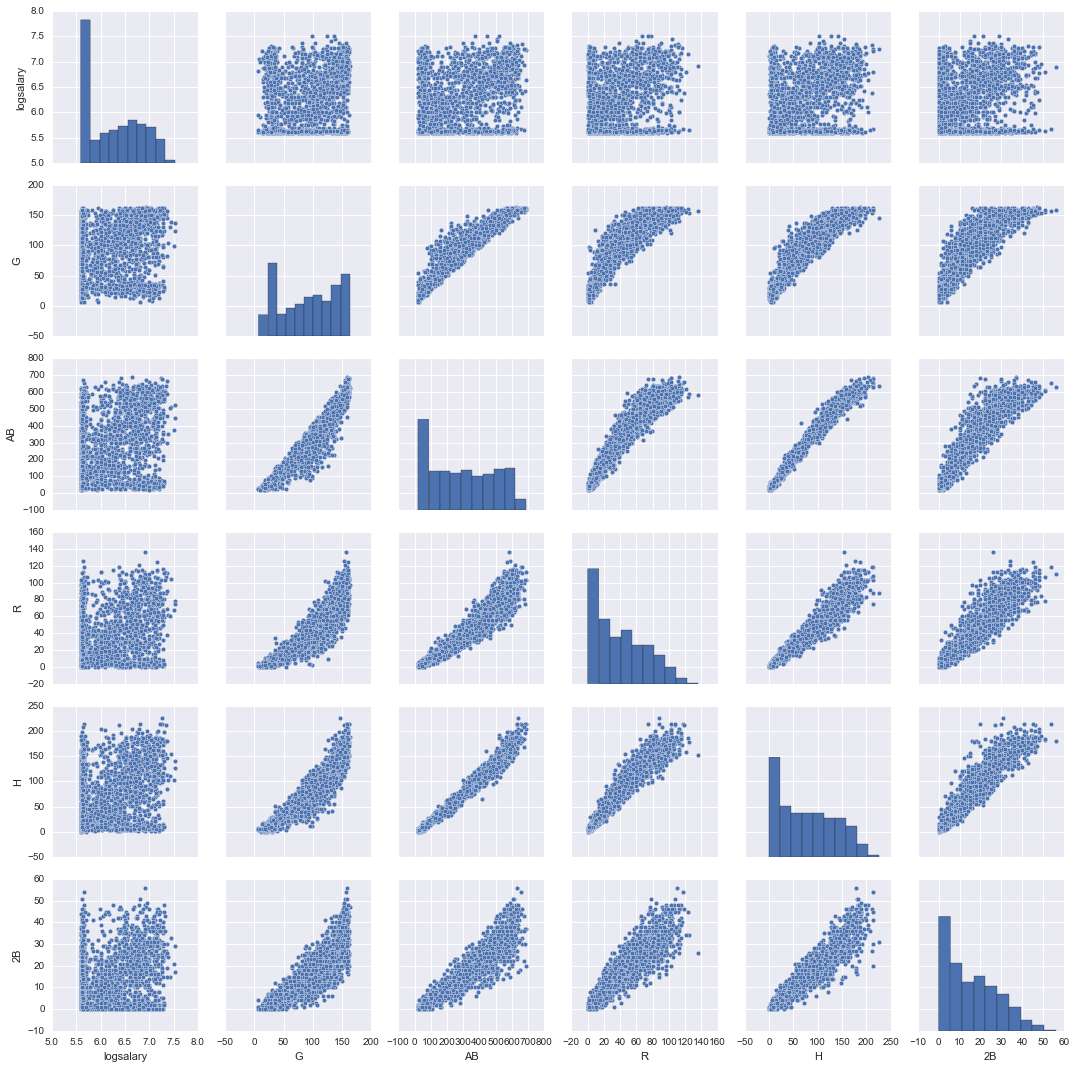

In [332]:
##SAMPLE PLOTTING

plot_vars_1=['logsalary','G','AB','R','H','2B']
plot_vars_2=['logsalary','3B','HR','RBI','BB','IBB']
plot_vars_3=['logsalary','BA','OBP','SLG','OPS']

sns.pairplot(df,vars=plot_vars_1);

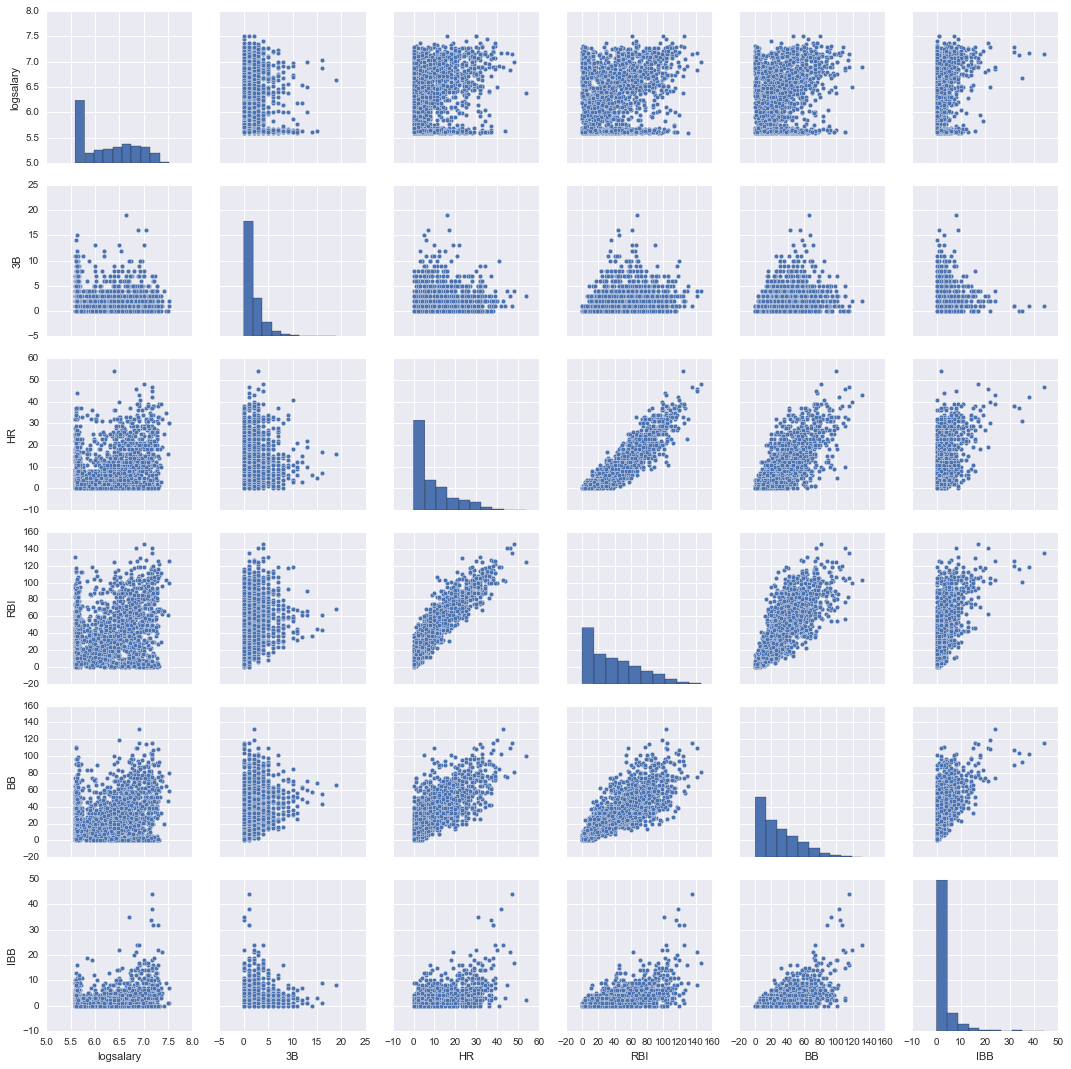

In [333]:
sns.pairplot(df,vars=plot_vars_2);

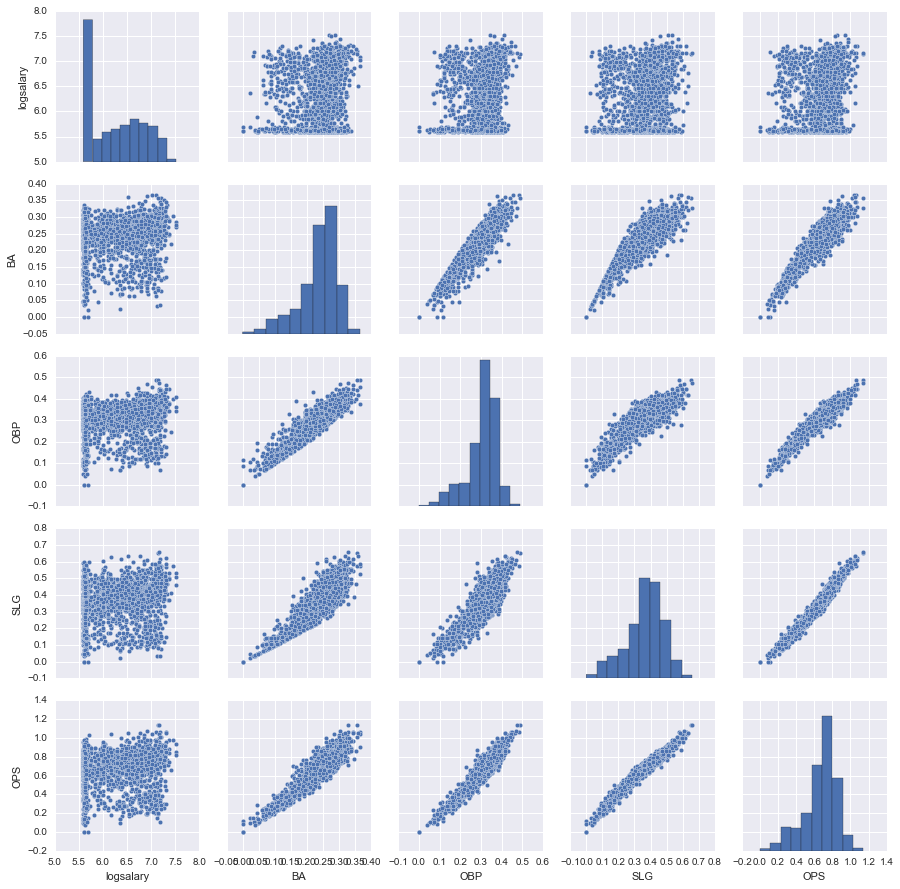

In [334]:
sns.pairplot(df,vars=plot_vars_3);

ADD COMMENTARY!!!!

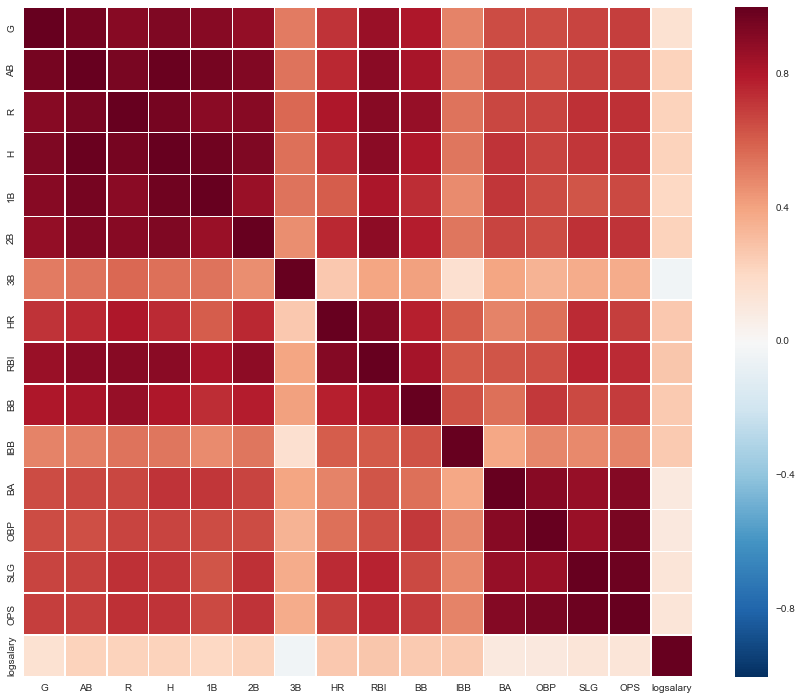

In [345]:
# Make a dataframe with the selected features and the target variable
feature_vars=['G','AB','R','H','1B','2B','3B','HR','RBI','BB','IBB','BA','OBP','SLG','OPS']
df_final = df[feature_vars+['logsalary']] #select subset of columns

##Create a correlation heatmap
cor_mat = df_final.corr()
f, ax = plt.subplots(figsize=(15, 12))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cor_mat,linewidths=.5, ax=ax);

In [354]:
Y=df.logsalary 
X=df[feature_vars]

corr_dict={feature:{'pearsonr': stats.pearsonr(X[feature].values,Y.values)[0],
                   'pval': stats.pearsonr(X[feature].values,Y.values)[1]} for feature in X.keys()}

corr_df=pd.DataFrame.from_dict(corr_dict,orient='index')
corr_df.sort_values('pearsonr',ascending=False)

,pearsonr,pval
RBI,0.280463,1.904134e-35
HR,0.273048,1.289743e-33
IBB,0.260371,1.290842e-30
BB,0.259516,2.030145e-30
H,0.233973,7.027311e-25
2B,0.230069,4.341918e-24
R,0.229637,5.301416e-24
AB,0.228371,9.488119e-24
1B,0.209339,3.943135e-20
G,0.153790,1.865898e-11


                                                Notes to Ian

- Plot salary vs position? --> add outfielding data
- Add college data?
 
- other data from Master's table

- plot team payrolls over time
- include conclusions section with opportunities for future work (i.e. including agents, contract extension, resigning etc.)